###Forest Cover Type Prediction

In [41]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from IPython.display import clear_output

In [85]:
df = pd.read_csv('train.csv', header=0)
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [62]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

In this notebook, we will explore data obtained from the US Geological Survey and USFS for 30x30 areas.  This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. Using this data, we are to best predict the type of cover that these forests provide, broken into 7 categories: spruce/fir, lodgepole pine, ponderosa pine, cottonwood/willow, aspen, douglas-fir, and krummholz.  

The first step in dealing with this data will be to clean up the raw data.

In [86]:
# Drop the ID and last column (Cover Type)
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [6]:
# Store the cover type in labels
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120L,)

In [7]:
for column in data.columns:
    print(data[column].describe(), "\n")

(count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64, '\n')
(count    15120.000000
mean       156.676653
std        110.085801
min          0.000000
25%         65.000000
50%        126.000000
75%        261.000000
max        360.000000
Name: Aspect, dtype: float64, '\n')
(count    15120.000000
mean        16.501587
std          8.453927
min          0.000000
25%         10.000000
50%         15.000000
75%         22.000000
max         52.000000
Name: Slope, dtype: float64, '\n')
(count    15120.000000
mean       227.195701
std        210.075296
min          0.000000
25%         67.000000
50%        180.000000
75%        330.000000
max       1343.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64, '\n')
(count    15120.000000
mean        51.076521
std         61.239406
min       -146.000000
25%          5.000000
50%      

In [48]:
# # remove columns with no variance
# for column in data.columns:
#     if data[column].std() == 0:
#         print('Drop column: {}'.format(column))
#         data.drop([column], axis=1, inplace=True)

# print(data.shape)

In [38]:
data.groupby(df[df.columns[len(df.columns) - 1]]).size()

# all cover types have an equal number of data points

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.33, random_state=42)

In [9]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

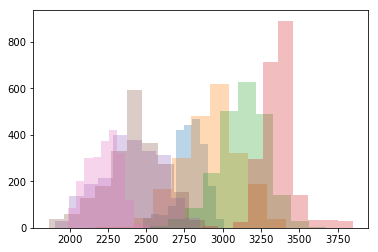

In [10]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for label in labels.unique():
    plt.hist(data.Elevation[labels==label], **kwargs)

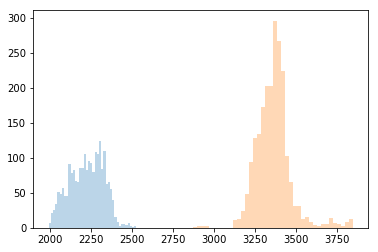

In [11]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

plt.hist(data.Elevation[labels==4], **kwargs)
plt.hist(data.Elevation[labels==7], **kwargs);

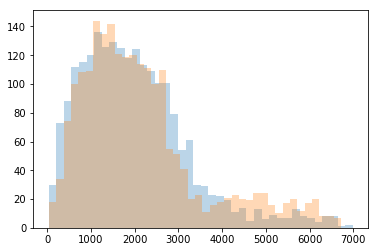

In [12]:
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==1], **kwargs)
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==2], **kwargs);

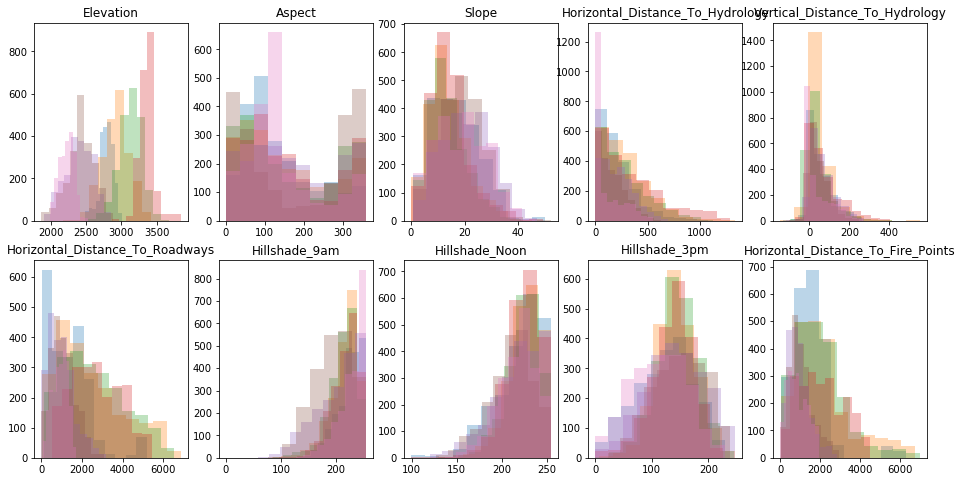

In [13]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in labels.unique():
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

From this, we can see that elevation has the most amount of variability between the different cover types.  This will be one of the main variable we look at when doing further analysis.

In [39]:
vars = [x for x in data.columns.tolist() if "Soil_Type" not in x]
vars = [x for x in vars if "Wilderness" not in x]
df1 = data.reindex(columns=vars)

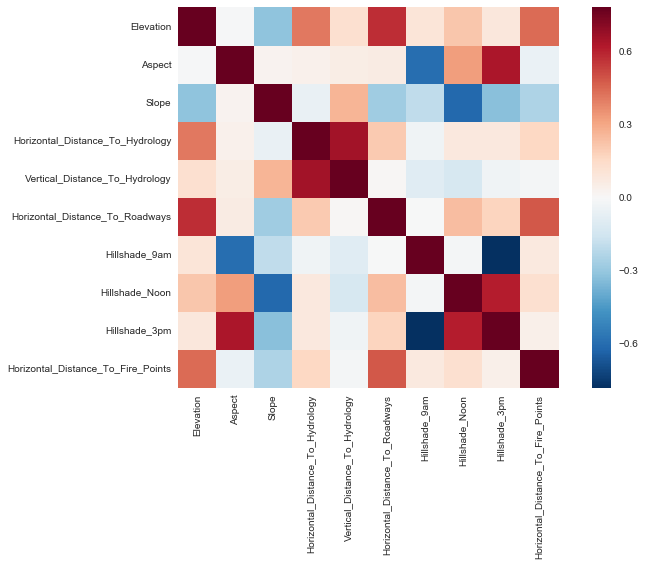

In [42]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corrmat, vmax=.5, square=True);

From this, we can see several things. First, the vertical and horizonal distances are pretty strongly correlated.  Second, the HIllshade_3pm is positively correlated with Hillsahde_noon, and negatively correlated with Hillshade_9am.  We can also see that there is a positive correlation with aspect as well.

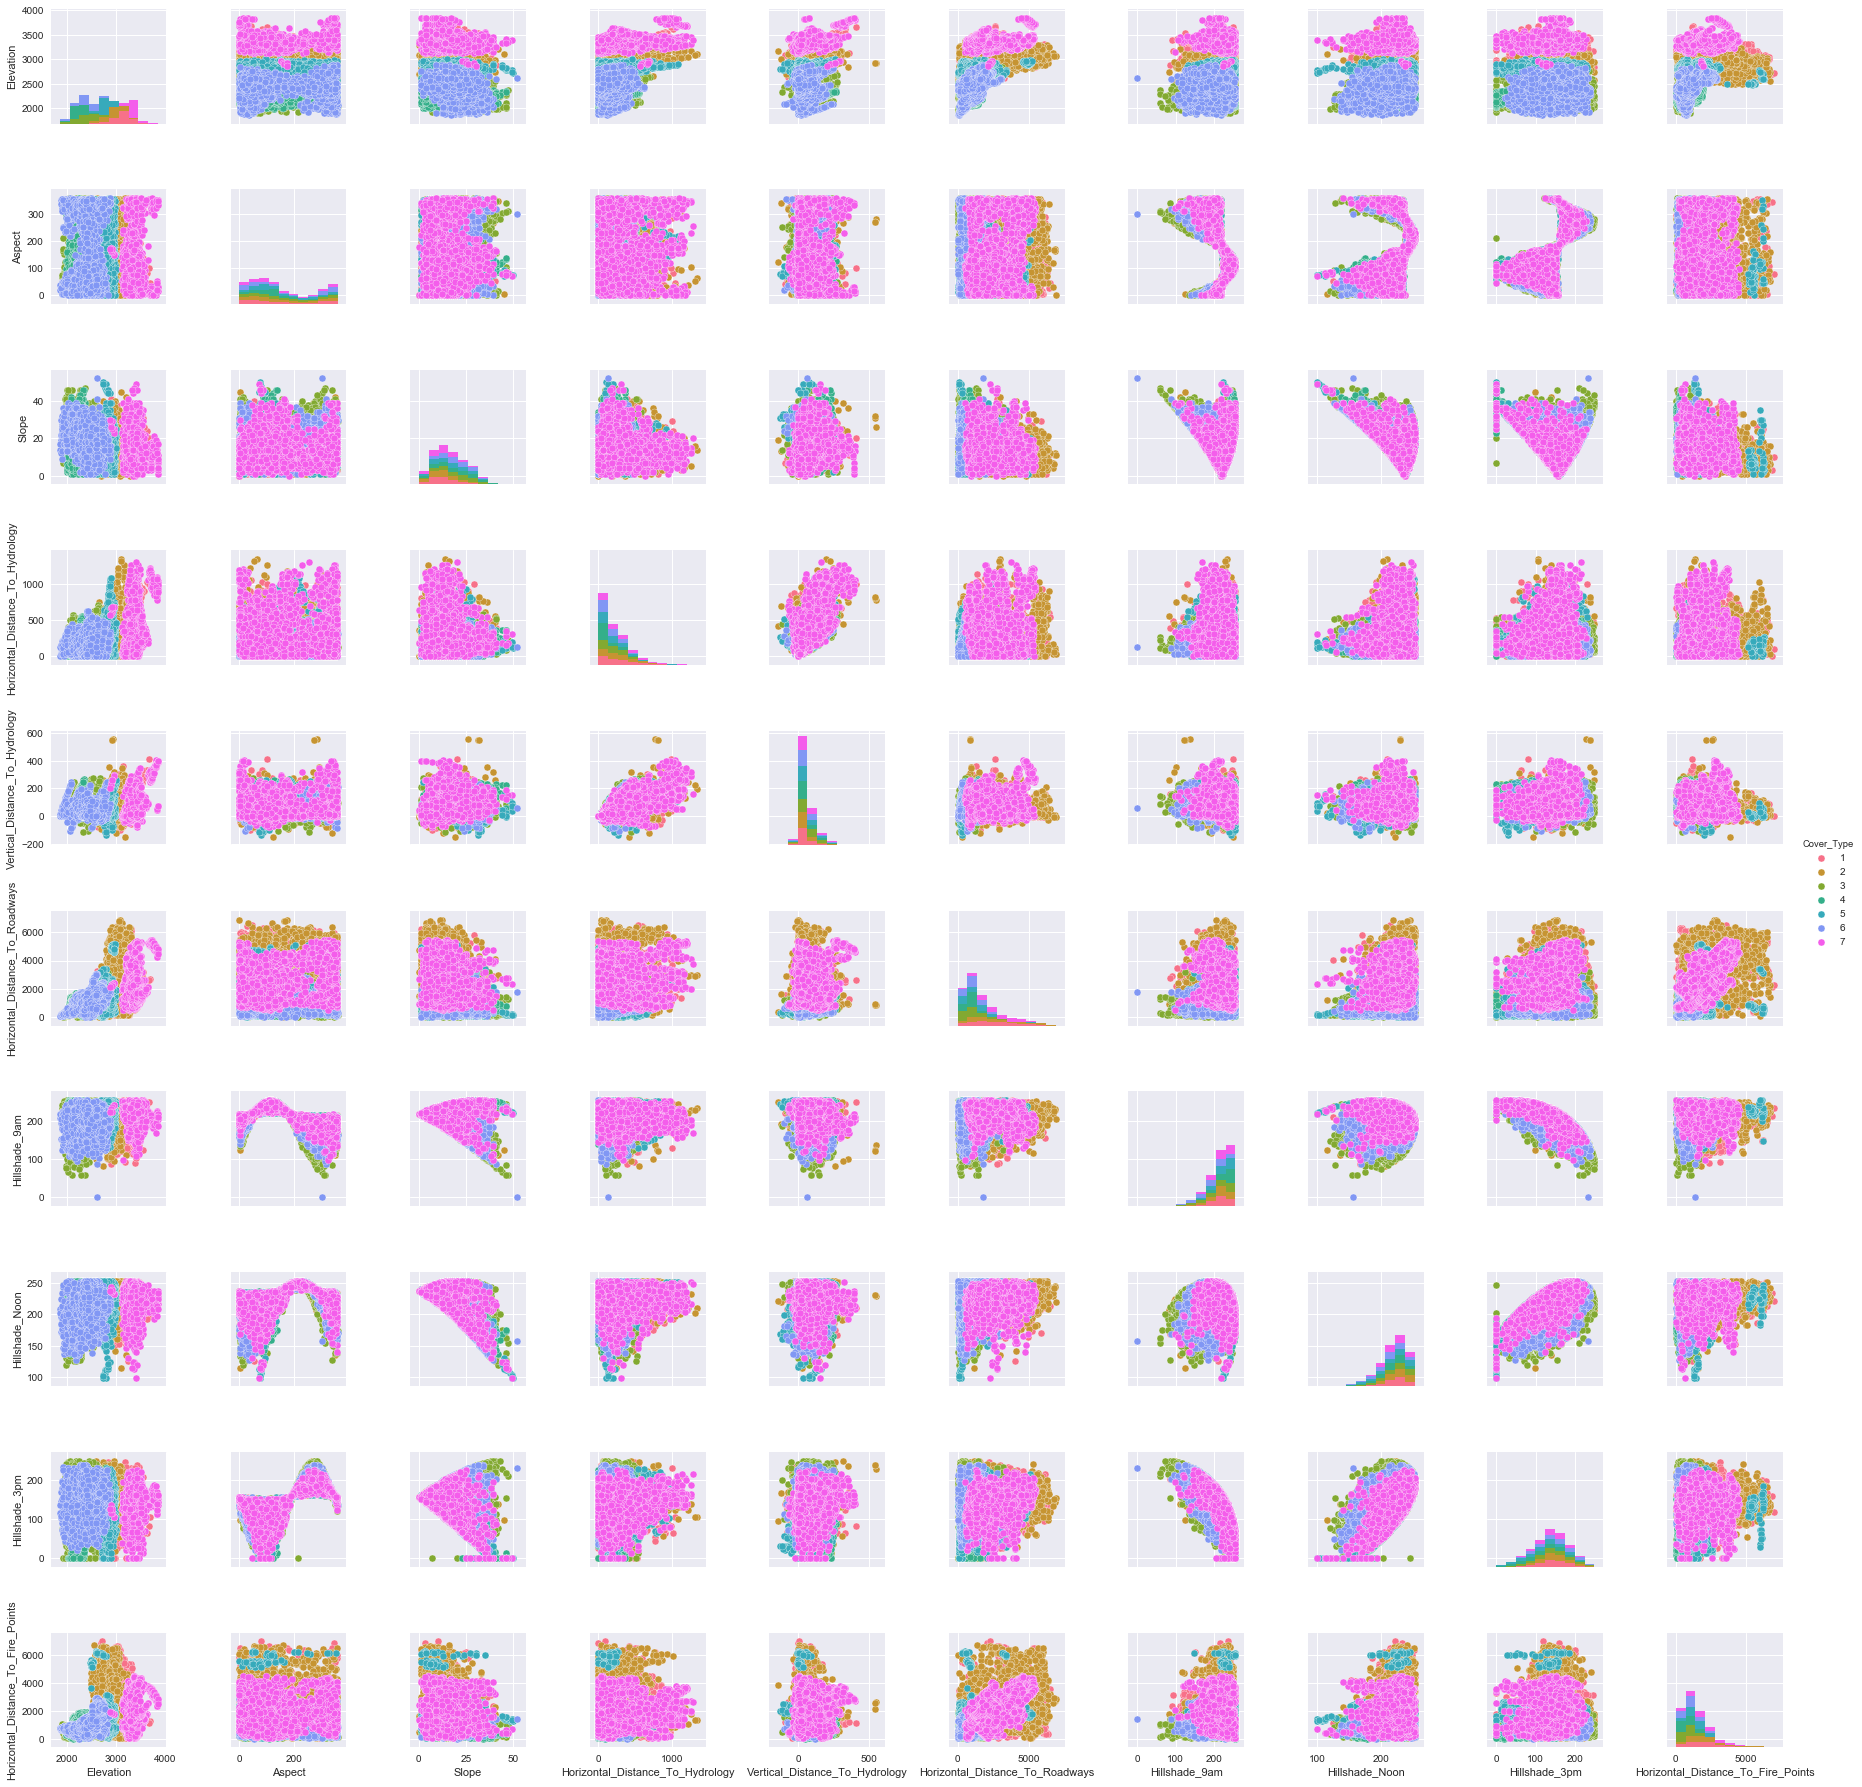

In [48]:
g = sns.pairplot(df, vars=vars, hue="Cover_Type")

In [14]:
# Count different soil types
data.loc[:, 'Soil_Type1':'Soil_Type40'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [50]:
col_names = df.columns.tolist()
A = np.array(col_names)
soil_types = [item for item in A if "Soil" in item]
for soil_type in soil_types:
    print (soil_type, df[soil_type].sum())

('Soil_Type1', 355)
('Soil_Type2', 623)
('Soil_Type3', 962)
('Soil_Type4', 843)
('Soil_Type5', 165)
('Soil_Type6', 650)
('Soil_Type7', 0)
('Soil_Type8', 1)
('Soil_Type9', 10)
('Soil_Type10', 2142)
('Soil_Type11', 406)
('Soil_Type12', 227)
('Soil_Type13', 476)
('Soil_Type14', 169)
('Soil_Type15', 0)
('Soil_Type16', 114)
('Soil_Type17', 612)
('Soil_Type18', 60)
('Soil_Type19', 46)
('Soil_Type20', 139)
('Soil_Type21', 16)
('Soil_Type22', 345)
('Soil_Type23', 757)
('Soil_Type24', 257)
('Soil_Type25', 1)
('Soil_Type26', 54)
('Soil_Type27', 15)
('Soil_Type28', 9)
('Soil_Type29', 1291)
('Soil_Type30', 725)
('Soil_Type31', 332)
('Soil_Type32', 690)
('Soil_Type33', 616)
('Soil_Type34', 22)
('Soil_Type35', 102)
('Soil_Type36', 10)
('Soil_Type37', 34)
('Soil_Type38', 728)
('Soil_Type39', 657)
('Soil_Type40', 459)


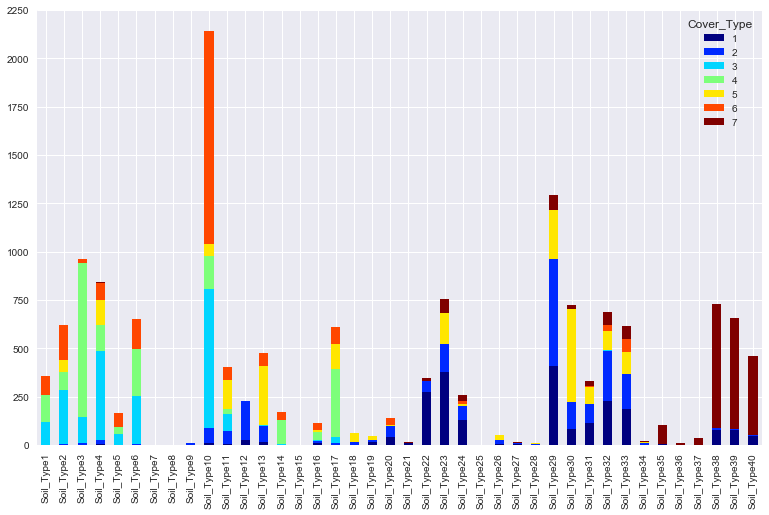

In [51]:
types_sum = df[soil_types].groupby(df['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(13,8), cmap='jet')

In [15]:
# Count at different wilderness areass
data.loc[:, 'Wilderness_Area1':'Wilderness_Area4'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

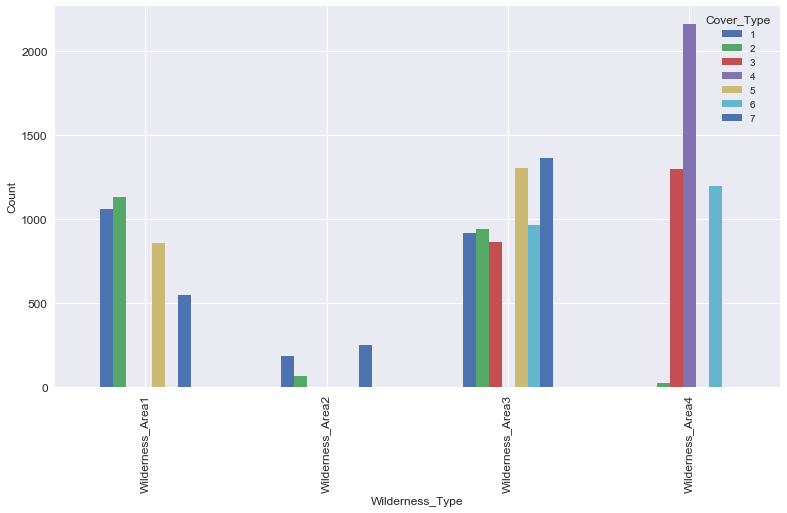

In [52]:
col_names_wilderness = [x for x in df.columns.tolist() if "Wilderness" in x]
types_sum = df[col_names_wilderness].groupby(df['Cover_Type']).sum()
ax = types_sum.T.plot(kind='bar', figsize=(13, 7), legend=True, fontsize=12)
ax.set_xlabel("Wilderness_Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

### PCA

In [16]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

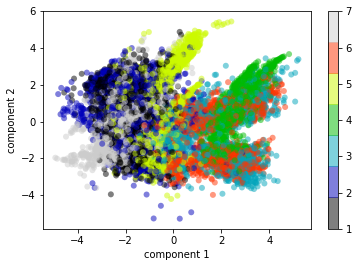

In [17]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

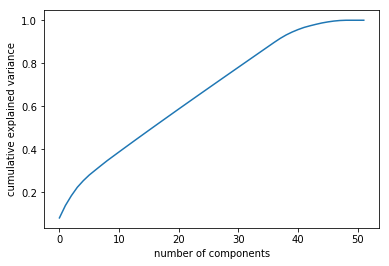

In [18]:
pca = PCA(n_components=52)
pca.fit(X_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## SVM

In [19]:
model = make_pipeline(SVC())

param_grid = {
    'svc__kernel': ['linear', 'rbf'],  # 'linear', 'rbf'
    'svc__C': [50, 100, 200],  # 1, 5, 10, 50, 100, 200
    'svc__gamma': [.01, .05, .1]}  # 0.0001, 0.0005, 0.001, 0.005, .01, .1
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
%time grid.fit(X_train_std, y_train)

Wall time: 4min 32s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svc__gamma': [0.01, 0.05, 0.1], 'svc__kernel': ['linear', 'rbf'], 'svc__C': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [20]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)

{'svc__gamma': 0.05, 'svc__kernel': 'rbf', 'svc__C': 100}


In [21]:
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.73      0.72      0.73       679
   2 - Lodgepole Pine       0.72      0.65      0.68       722
   3 - Ponderosa Pine       0.80      0.75      0.77       704
4 - Cottonwood/Willow       0.91      0.96      0.93       739
            5 - Aspen       0.88      0.91      0.89       721
      6 - Douglas-fir       0.80      0.83      0.82       722
        7 - Krummholz       0.93      0.97      0.95       703

          avg / total       0.83      0.83      0.83      4990



## Logistic Regression

In [22]:
model = make_pipeline(PCA(), PolynomialFeatures(), LogisticRegression())
c_vals = [1, 2, 4, 10] #[.0001, 0.001, 0.01, 0.1, 1, 2, 4, 10, 20, 50, 100]
tol = [.01]
param_grid = {
    'pca__n_components': range(21, 23),
    'polynomialfeatures__degree': range(1, 3),
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': ['l2', 'l1']
}
grid = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=6)
%time grid.fit(X_train_std, y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

KeyboardInterrupt: 

In [ ]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

## GMM

In [109]:
def run_exp(pca_n, gmm_n, cov_type):

    pca = PCA(n_components=pca_n)
    pca.fit(X_train_std)
    X_train_pca = pca.transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    
    all_scores = np.zeros(y_test.shape)
    for label in range(1, len(target_names) + 1):
        X = X_train_pca[np.where(y_train == label)]
        gmm = GaussianMixture(n_components=gmm_n,
                              covariance_type=cov_type)
        gmm.fit(X)
        scores = gmm.score_samples(X_test_pca)
        all_scores = np.column_stack((all_scores, scores))
        
    all_scores = np.delete(all_scores, (0), axis=1)
    
    # choose the max index for each row for pred
    y_pred = all_scores.argmax(axis=1)
    y_pred = y_pred + 1
    accuracy = np.mean(y_pred == y_test)
    return accuracy

matrix_types = ('spherical', 'diag', 'tied', 'full')
n_pca_components = range(1, 55)
n_gmm_components = range(1, 55)
accuracies = []

for cov_type in matrix_types:
    for pca_n in n_pca_components:
        for gmm_n in n_gmm_components:
            accuracy = run_exp(pca_n=pca_n, 
                               gmm_n=gmm_n,
                               cov_type=cov_type)
            accuracies.append({'accuracy': accuracy, 'cov_type': cov_type,
                               'pca_n': pca_n, 'gmm_n': gmm_n})
            clear_output()
            print(len(accuracies))

print(sorted(accuracies, key=lambda k: k['accuracy'])[-1])

11664
{'pca_n': 9, 'cov_type': 'full', 'gmm_n': 42, 'accuracy': 0.80781563126252509}


## Forest Methods

In [79]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(X_train_std, y_train)

print ('Accuracy (a decision tree):', dt.score(X_test_std, y_test))

Accuracy (a decision tree): 0.781563126253


In [554]:
model = make_pipeline(RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 500, 1000, 5000], 
    'randomforestclassifier__criterion': ['entropy', 'gini'],
    'randomforestclassifier__max_features': [None, 'sqrt', .5, .75],
    'randomforestclassifier__max_depth': [None, 20, 30],
    'randomforestclassifier__bootstrap': [True, False],
}
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=6, verbose=1)
%time grid.fit(X_train_std, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 32.7min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 78.6min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed: 147.7min finished


CPU times: user 35.9 s, sys: 3.38 s, total: 39.3 s
Wall time: 2h 28min 10s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=6,
       param_grid={'randomforestclassifier__criterion': ['entropy', 'gini'], 'randomforestclassifier__max_depth': [None, 20, 30], 'randomforestclassifier__bootstrap': [True, False], 'randomforestclassifier__n_estimators': [100, 200, 500, 1000, 5000], 'randomforestclassifier__max_features': [None, 'sqrt', 0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [555]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test_std)
print(classification_report(y_test, y_pred, target_names=target_names))

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__bootstrap': False, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__max_features': 'sqrt'}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.78      0.78      0.78       679
   2 - Lodgepole Pine       0.80      0.69      0.74       722
   3 - Ponderosa Pine       0.84      0.82      0.83       704
4 - Cottonwood/Willow       0.93      0.98      0.95       739
            5 - Aspen       0.90      0.95      0.92       721
      6 - Douglas-fir       0.86      0.88      0.87       722
        7 - Krummholz       0.95      0.97      0.96       703

          avg / total       0.87      0.87      0.87      4990



In [82]:
abc = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0), 
    n_estimators=200, learning_rate=0.1)

abc.fit(X_train_std, y_train)
print ('Accuracy (adaboost with decision trees):', abc.score(X_test_std, y_test))

Accuracy (adaboost with decision trees): 0.77875751503


In [25]:
def run_rand_forest(X_train, y_train, X_test, y_test): 
    rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features='sqrt', n_jobs=-1)
    rfc.fit(X_train, y_train)
    accuracy = rfc.score(X_test, y_test)
    return accuracy

def run_ridge(X_train, y_train, X_test, y_test, alpha=.1):
    ridge = RidgeClassifier(alpha=alpha, normalize=True)
    ridge.fit(X_train, y_train)
    return ridge.score(X_test, y_test)

In [56]:
run_rand_forest(X_train, y_train, X_test, y_test)

0.85651302605210422

In [57]:
run_rand_forest(X_train_std, y_train, X_test_std, y_test)

0.86012024048096192

## Feature Engineering

In [23]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.33, random_state=40)
    return X_train, y_train, X_test, y_test

In [26]:
run_rand_forest(X_train.as_matrix()[:, 0:10], y_train, X_test.as_matrix()[:, 0:10], y_test)

0.82625250501002001

In [60]:
run_ridge(X_train, y_train, X_test, y_test, )

0.62645290581162327

In [61]:
run_rand_forest(X_train.as_matrix()[:, 11:15], y_train, X_test.as_matrix()[:, 11:15], y_test)

0.33046092184368736

In [62]:
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='sqrt', n_jobs=-1)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
np.mean(preds == y_test)

0.86012024048096192

In [63]:
# msk = (y_test == 1) & (preds != 1)
# X_test.ix[msk]

### Binning hillshade_noon

In [64]:
noon_bins = np.linspace(0, 255, 4)
which_bin = np.digitize(X_train.Hillshade_Noon, bins=noon_bins)

encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin.reshape(-1, 1))
X_train_noon_binned = encoder.transform(which_bin.reshape(-1, 1))

In [35]:
#X_train_with_binned = np.hstack([X_train.drop('Hillshade_Noon', axis=1), X_train_noon_binned])

which_bin = np.binarize(X_test.Hillshade_Noon)
X_test_noon_binned = encoder.transform(which_bin.reshape(-1, 1))
X_test_with_binned = np.hstack([X_test.drop('Hillshade_Noon', axis=1), X_test_noon_binned])

AttributeError: 'module' object has no attribute 'binarize'

In [66]:
run_rand_forest(X_train_with_binned, y_train, X_test_with_binned, y_test)

0.86252505010020042

### Convert aspect to cardinal direction (north, south, east, west)

In [31]:

new_data = data.copy(deep=True)
dir_labels = ['north east', 'east north', 'east south', 'south east', 
          'south west', 'west south', 'west north', 'north west']
new_data.loc[:, ('direction')] = pd.cut(data.loc[:, ('Aspect')], range(0, 365, 45), right=False, labels=dir_labels)

new_data.direction = new_data.direction.replace('east north', 'north') \
    .replace('north west', 'west') \
    .replace('east north', 'north').replace('east south', 'south').replace('south east', 'east') \
    .replace('south west', 'west').replace('west south', 'south').replace('west north', 'north') \
    .replace('north east', 'east')

In [32]:
new_data = pd.get_dummies(new_data)
new_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,direction_east,direction_north,direction_south,direction_west
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,1,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,1,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,1,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,1,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,1,0,0


In [33]:
run_rand_forest(*split_data(new_data, labels))

0.85190380761523044

In [70]:
run_ridge(*split_data(new_data, labels))

0.62505010020040075

### Convert horizontal and vertical distance to hydrology to euclidean distance

In [71]:
new_data = data.copy(deep=True)

new_data.loc[:, ('euclid_to_hydro')] = np.sqrt(new_data.Horizontal_Distance_To_Hydrology ** 2 \
                                               + new_data.Vertical_Distance_To_Hydrology ** 2)
new_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,euclid_to_hydro
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,258.000000
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,212.084889
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,275.769832
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,269.235956
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,153.003268


In [72]:
run_rand_forest(*split_data(new_data, labels))

0.85591182364729457

In [73]:
run_ridge(*split_data(new_data, labels))

0.62284569138276558

### Multiply elevation and Slope

In [104]:
def multiply_elevation_slope(data=None):
    new_data = data.copy(deep=True)
    new_data.loc[:, ('elevation_x_slope')] = new_data.Elevation * new_data.Slope
    return new_data

new_data = multiply_elevation_slope(data)
new_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,elevation_x_slope
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,7788
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5180
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,25236
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,50130
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5190


In [102]:
run_rand_forest(*split_data(new_data, labels))

0.85551102204408813

In [105]:
model = make_pipeline(StandardScaler(), PolynomialFeatures(), LogisticRegression())
c_vals = [10]
tol = [.01]
param_grid = {
    'polynomialfeatures__degree': range(2, 3),
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': ['l2']
}
grid = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=-1)

new_X_train, new_y_train, new_X_test, new_y_test = split_data(new_data, labels)

%time grid.fit(new_X_train, new_y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(new_X_test)
print('Accuracy: {}'.format(np.mean(y_pred == new_y_test)))

CPU times: user 2min 29s, sys: 488 ms, total: 2min 30s
Wall time: 4min 41s
Best params for Logistic Regression: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.01, 'polynomialfeatures__degree': 2}
{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.01, 'polynomialfeatures__degree': 2}
Accuracy: 0.7777555110220441


In [106]:
model = make_pipeline(StandardScaler(), PolynomialFeatures(), LogisticRegression())
c_vals = [10]
tol = [.01]
param_grid = {
    'polynomialfeatures__degree': range(2, 3),
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': ['l2']
}
grid = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=-1)

new_X_train, new_y_train, new_X_test, new_y_test = split_data(data, labels)

%time grid.fit(new_X_train, new_y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(new_X_test)
print('Accuracy: {}'.format(np.mean(y_pred == new_y_test)))

CPU times: user 1min 58s, sys: 459 ms, total: 1min 59s
Wall time: 3min 53s
Best params for Logistic Regression: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.01, 'polynomialfeatures__degree': 2}
{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.01, 'polynomialfeatures__degree': 2}
Accuracy: 0.7785571142284569


In [ ]:
## add all types of soils

In [29]:
def multiply_elevation_slope(data=None):
    new_data = data.copy(deep=True)
    new_data.loc[:, ('elevation_div_slope')] = new_data.Elevation * new_data.Slope
    return new_data

new_data = multiply_elevation_slope(data)
new_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,elevation_div_slope
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,7788
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5180
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,25236
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,50130
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5190


In [30]:
run_rand_forest(*split_data(new_data, labels))

0.85370741482965928

We can try calculating slope distance and slop% using the formula:  
\[slope = \sqrt{(verticaldistance)^2 + (horizontaldistance)^2}\]

\[slope~ percent = \frac{rise}{run}*{100}\]


In [80]:
#Create two new columns named Slope hydrology and Slope hydrology percent and remove any infinite values that may result 
data['slope_hyd'] = np.sqrt(data.Vertical_Distance_To_Hydrology**2 + data.Horizontal_Distance_To_Hydrology**2) 
data.slope_hyd=data.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
data['slope_hyd_pct'] = data.Vertical_Distance_To_Hydrology / data.Horizontal_Distance_To_Hydrology
data.slope_hyd_pct=data.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

In [81]:
data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Mean_Amenities,Mean_Fire_Hyd,slope_hyd,slope_hyd_pct
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,2349.000000,3268.5,258.000000,0.000000
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,2275.666667,3218.5,212.084889,-0.028302
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,3189.666667,3194.5,275.769832,0.242537
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,3181.000000,3226.5,269.235956,0.487603
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,2238.666667,3162.5,153.003268,-0.006536
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,2132.666667,3165.5,300.374766,-0.050000
6,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,2386.333333,3263.0,270.046292,0.018519
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,2345.000000,3231.0,234.104677,0.029915
8,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,2383.333333,3242.0,246.446749,0.233333
9,2612,59,10,247,11,636,228,219,124,6230,...,0,0,0,0,0,0,2371.000000,3238.5,247.244818,0.044534


In [92]:
run_rand_forest(*split_data(data, labels))

0.87935871743486971

In [89]:
#Mean distance to Amenities 
data['Mean_Amenities']=(data.Horizontal_Distance_To_Fire_Points + data.Horizontal_Distance_To_Hydrology + data.Horizontal_Distance_To_Roadways) / 3 

#Mean Distance to Fire and Water 
data['Mean_Fire_Hyd']=(data.Horizontal_Distance_To_Fire_Points + data.Horizontal_Distance_To_Hydrology) / 2 


In [65]:
data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Mean_Amenities,Mean_Fire_Hyd
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,2349.000000,3268.5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,2275.666667,3218.5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,3189.666667,3194.5
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,3181.000000,3226.5
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,2238.666667,3162.5
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,2132.666667,3165.5
6,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,2386.333333,3263.0
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,2345.000000,3231.0
8,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,2383.333333,3242.0
9,2612,59,10,247,11,636,228,219,124,6230,...,0,0,0,0,0,0,0,0,2371.000000,3238.5


In [66]:
run_rand_forest(*split_data(data, labels))

0.87394789579158316

In [79]:
data.ix[:,14:54].sum(axis=1)

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
15090    1
15091    1
15092    1
15093    1
15094    1
15095    1
15096    1
15097    1
15098    1
15099    1
15100    1
15101    1
15102    1
15103    1
15104    1
15105    1
15106    1
15107    1
15108    1
15109    1
15110    1
15111    1
15112    1
15113    1
15114    1
15115    1
15116    1
15117    1
15118    1
15119    1
dtype: int64

In [91]:
#Elevation adjusted by Horizontal distance to Hyrdrology 
data['Elev_to_HD_Hyd']=data.Elevation - data.Horizontal_Distance_To_Hydrology 
#testcsv['Elev_to_HD_Hyd']=testcsv.Elevation - 0.2 * testcsv.Horizontal_Distance_To_Hydrology 

#Elevation adjusted by Horizontal distance to Roadways 
data['Elev_to_HD_Road']=data.Elevation - data.Horizontal_Distance_To_Roadways 
#testcsv['Elev_to_HD_Road']=testcsv.Elevation - 0.05 * testcsv.Horizontal_Distance_To_Roadways 

#Elevation adjusted by Vertical distance to Roadways 
data['Elev_to_VD_Hyd']=data.Elevation - data.Vertical_Distance_To_Hydrology 
#testcsv['Elev_to_VD_Hyd']=testcsv.Elevation - testcsv.Vertical_Distance_To_Hydrology 

## Test results

In [74]:
test_df = pd.read_csv("../data/test.csv")
#test_df = test_df.drop(['Id'], axis=1)
test_df.head()

# remove columns with no variance
for column in test_df.columns:
    if test_df[column].std() == 0:
        print('Drop column: {}'.format(column))
        #test_df.drop([column], axis=1, inplace=True)

print(test_df.shape)

(565892, 55)


In [75]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=30, 
                             bootstrap=False, n_estimators=1000, 
                             max_features='sqrt', n_jobs=-1)
rfc.fit(data, labels)

test_df['Cover_Type'] = pd.Series(rfc.predict(test_df.drop(['Id'], axis=1)))

submission = pd.concat([test_df['Id'].astype(int), test_df['Cover_Type']], axis=1)
submission = submission.set_index('Id')
submission.to_csv('submission.csv')
submission.head()

,Cover_Type
Id,
15121,2
15122,1
15123,2
15124,2
15125,2


In [76]:
submission.shape

(565892, 1)